In [ ]:
import tensorflow_datasets as tfds

In [ ]:
list_tfds = tfds.list_builders()


In [ ]:
(train_data,test_data) , tfds_info = tfds.load(name="food101",as_supervised=True,split=["train","validation"],shuffle_files=True,with_info=True)
# as_supervised = true means the data will be loaded in the form of tuple (input,label)
# we as creaed new var (tfds_info) as we want info from this dataset and for this we need to enable  (with_info=True).

In [ ]:
!nvidia-smi

Fri Jul 14 04:06:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    51W / 400W |    709MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tfds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
label_names = tfds_info.features["label"].names
label_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
one_sample=train_data.take(1)
one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image,label in one_sample:
  print(f"image shape-> {image.shape}, data_type-> {image.dtype} , label_name(tensor_form)-> {label}, class_name-> {label_names[label.numpy()]}")

image shape-> (512, 512, 3), data_type-> <dtype: 'uint8'> , label_name(tensor_form)-> 21, class_name-> chocolate_cake


(-0.5, 511.5, 511.5, -0.5)

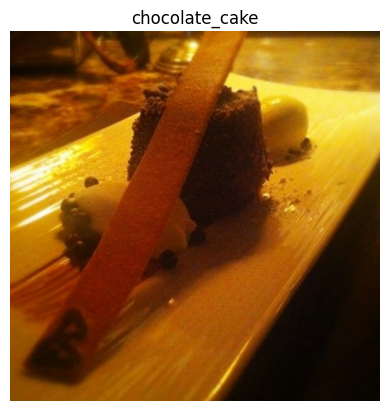

In [ ]:
import matplotlib.pyplot as mpl
mpl.imshow(image)
mpl.title(label_names[label.numpy()])
mpl.axis(False)

In [ ]:
# now we want to preprocess our image (like adjusting the size,shape, and normalize it using a custom function)

def preprocess_image(image,label,img_size=224):
  img = tf.image.resize(image,size=[img_size,img_size])
  return tf.cast(img,dtype=tf.float32), label

In [ ]:
import tensorflow as tf
pr1 = preprocess_image(image,label)[0]
print(f"shape before preprocessed {image.shape} and its dtype {image.dtype}")
print(f" after preprocessed {pr1} shape is {pr1.shape}  and its dtype {pr1.dtype}")

shape before preprocessed (512, 512, 3) and its dtype <dtype: 'uint8'>
 after preprocessed [[[2.9198980e+01 1.1198979e+01 0.0000000e+00]
  [2.8285715e+01 1.2285714e+01 0.0000000e+00]
  [3.0852041e+01 1.5494898e+01 2.8061217e-01]
  ...
  [5.2933601e+01 3.2505074e+01 8.7193365e+00]
  [5.4025528e+01 3.4025528e+01 1.0025528e+01]
  [5.3800972e+01 3.3800972e+01 9.5713587e+00]]

 [[3.3096939e+01 1.5096939e+01 1.1938781e+00]
  [3.3785713e+01 1.7785715e+01 2.7857151e+00]
  [3.1785713e+01 1.6428572e+01 1.2142859e+00]
  ...
  [6.3602058e+01 4.2530632e+01 1.5346998e+01]
  [6.1647934e+01 4.0785702e+01 1.3928558e+01]
  [6.0785713e+01 4.1714287e+01 1.2020403e+01]]

 [[3.1576530e+01 1.3576531e+01 6.4285755e-01]
  [3.3357147e+01 1.7357143e+01 2.3571434e+00]
  [3.6168365e+01 2.0811226e+01 5.5969391e+00]
  ...
  [6.7688797e+01 4.4474506e+01 1.0852092e+01]
  [6.9959167e+01 4.6943893e+01 1.1984691e+01]
  [6.7994888e+01 4.7566319e+01 1.1280604e+01]]

 ...

 [[1.3714288e+02 8.0142876e+01 1.1428789e+00]
  [1.

In [ ]:
# creating a tupple
# this is small example of what we have done here above assigning it to the [0] index
tupple = ("pawan",12,"scooby")
copy_tupple =  ()
copy_tupple = tupple[0]
copy_tupple

'pawan'

In [ ]:
train_data = train_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image,num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)




In [ ]:
tbc = tf.keras.callbacks.TensorBoard(log_dir="tbb")
mcc = tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoint/cp.ckpt",monitor="val_acc",save_best_only=True)

**NOW WE SETUP MIXED PRECISION TRAINING**

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
base_model=tf.keras.applications.EfficientNetB3(include_top=False)

base_model.trainable = True

inputs = tf.keras.layers.Input(shape=(224,224,3))

x = base_model(inputs,training = False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(len(label_names)) (x)

outputs = tf.keras.layers.Activation("softmax",dtype=tf.float32) (x)

model_1 = tf.keras.Model(inputs,outputs)


model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, None, None, 1536)  10783535 
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               155237    
                                                                 
 activation_1 (Activation)   (None, 101)               0         
                                                                 
Total params: 10,938,772
Trainable params: 155,237
Non-trainable params: 10,783,535
_________________________________________

In [ ]:
for layer in model_1.layers:
  print(f"layer names{layer.name} and dtype {layer.dtype_policy} and trainable {layer.trainable}")

layer namesinput_8 and dtype <Policy "float32"> and trainable True
layer namesefficientnetb3 and dtype <Policy "mixed_float16"> and trainable False
layer namesglobal_average_pooling2d_2 and dtype <Policy "mixed_float16"> and trainable True
layer namesdense_2 and dtype <Policy "mixed_float16"> and trainable True
layer namesactivation_2 and dtype <Policy "float32"> and trainable True


In [ ]:
history_1=model_1.fit(train_data,steps_per_epoch=len(train_data),epochs=3,validation_data=test_data,validation_steps=(0.15*len(test_data)),callbacks=[mcc,tbc])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7682 - accuracy: 0.5561

2368/2368 [==============================] - 252s 88ms/step - loss: 1.7682 - accuracy: 0.5561 - val_loss: 1.1711 - val_accuracy: 0.6754
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 0.9464 - accuracy: 0.7445

2368/2368 [==============================] - 207s 87ms/step - loss: 0.9464 - accuracy: 0.7445 - val_loss: 1.3093 - val_accuracy: 0.6531
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.8095

2368/2368 [==============================] - 207s 87ms/step - loss: 0.6804 - accuracy: 0.8095 - val_loss: 0.8396 - val_accuracy: 0.7692


In [ ]:
import pandas as pd

In [ ]:
y_pred=model_1.predict(test_data)

790/790 [==============================] - 16s 20ms/step


In [ ]:
pred_classes=y_pred.argmax(axis=1)

In [ ]:
y_label = []
for image , label in test_data.unbatch():
  y_label.append(label.numpy().argmax())

print(y_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**NOW WE FINE TUNE OUR MODEL_1**

In [ ]:
for layer in model_1.layers:
  print(layer, layer.trainable), print(len(layer.trainable_variables))

<keras.engine.input_layer.InputLayer object at 0x7a4f777e6d70> True
0
<keras.engine.functional.Functional object at 0x7a4f81ec12d0> True
338
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a4f777e77c0> True
0
<keras.layers.core.dense.Dense object at 0x7a4f81b09000> True
2
<keras.layers.core.activation.Activation object at 0x7a4f813bf970> True
0


In [ ]:
for layers in model_1.layers[1].layers[288:]:
  layers.trainable = True
  print(f"layer name is {layers.name} and trainable = {layers.trainable}")

layer name is block6b_se_expand and trainable = True
layer name is block6b_se_excite and trainable = True
layer name is block6b_project_conv and trainable = True
layer name is block6b_project_bn and trainable = True
layer name is block6b_drop and trainable = True
layer name is block6b_add and trainable = True
layer name is block6c_expand_conv and trainable = True
layer name is block6c_expand_bn and trainable = True
layer name is block6c_expand_activation and trainable = True
layer name is block6c_dwconv and trainable = True
layer name is block6c_bn and trainable = True
layer name is block6c_activation and trainable = True
layer name is block6c_se_squeeze and trainable = True
layer name is block6c_se_reshape and trainable = True
layer name is block6c_se_reduce and trainable = True
layer name is block6c_se_expand and trainable = True
layer name is block6c_se_excite and trainable = True
layer name is block6c_project_conv and trainable = True
layer name is block6c_project_bn and trainable 

In [ ]:
for layer in model_1.layers:
  print(layer, layer.trainable), print(len(layer.trainable_variables))

<keras.engine.input_layer.InputLayer object at 0x7a4f777e6d70> True
0
<keras.engine.functional.Functional object at 0x7a4f81ec12d0> True
338
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a4f777e77c0> True
0
<keras.layers.core.dense.Dense object at 0x7a4f81b09000> True
2
<keras.layers.core.activation.Activation object at 0x7a4f813bf970> True
0


In [ ]:
for layer in model_1.layers[1].layers[300:]:
  layer.trainable = False
  print(f"layer name {layer.name} and trainable {layer.trainable}")

layer name block6c_se_squeeze and trainable False
layer name block6c_se_reshape and trainable False
layer name block6c_se_reduce and trainable False
layer name block6c_se_expand and trainable False
layer name block6c_se_excite and trainable False
layer name block6c_project_conv and trainable False
layer name block6c_project_bn and trainable False
layer name block6c_drop and trainable False
layer name block6c_add and trainable False
layer name block6d_expand_conv and trainable False
layer name block6d_expand_bn and trainable False
layer name block6d_expand_activation and trainable False
layer name block6d_dwconv and trainable False
layer name block6d_bn and trainable False
layer name block6d_activation and trainable False
layer name block6d_se_squeeze and trainable False
layer name block6d_se_reshape and trainable False
layer name block6d_se_reduce and trainable False
layer name block6d_se_expand and trainable False
layer name block6d_se_excite and trainable False
layer name block6d_pro

In [ ]:
for layer in model_1.layers:
  print(layer, layer.trainable), print(len(layer.trainable_variables))


<keras.engine.input_layer.InputLayer object at 0x7a4f777e6d70> True
0
<keras.engine.functional.Functional object at 0x7a4f81ec12d0> True
263
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a4f777e77c0> True
0
<keras.layers.core.dense.Dense object at 0x7a4f81b09000> True
2
<keras.layers.core.activation.Activation object at 0x7a4f813bf970> True
0


In [ ]:
fine_tune_epoch = 6

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer=tf.keras.optimizers.SGD(),metrics=["accuracy"])

history_2 =  model_1.fit(train_data,steps_per_epoch=len(train_data),epochs=fine_tune_epoch,validation_data=test_data,validation_steps=(0.15*len(test_data)),callbacks=[mcc,tbc],initial_epoch=history_1.epoch[-1])

Epoch 3/6
2368/2368 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.9154

2368/2368 [==============================] - 232s 83ms/step - loss: 0.3150 - accuracy: 0.9154 - val_loss: 0.8336 - val_accuracy: 0.7778
Epoch 4/6
2368/2368 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.9406

2368/2368 [==============================] - 197s 83ms/step - loss: 0.2371 - accuracy: 0.9406 - val_loss: 0.7336 - val_accuracy: 0.8067
Epoch 5/6
2368/2368 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9603

2368/2368 [==============================] - 196s 83ms/step - loss: 0.1747 - accuracy: 0.9603 - val_loss: 0.7328 - val_accuracy: 0.8130
Epoch 6/6
2368/2368 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9759

2368/2368 [==============================] - 196s 83ms/step - loss: 0.1233 - accuracy: 0.9759 - val_loss: 0.7581 - val_accuracy: 0.8080


<Axes: >

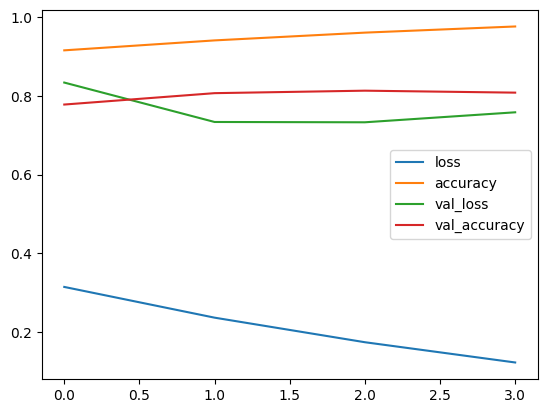

In [ ]:
pd.DataFrame(history_2.history).plot()

In [ ]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay

In [ ]:
cf = confusion_matrix(pred_classes,y_label)

In [ ]:
cfd = ConfusionMatrixDisplay(cf)

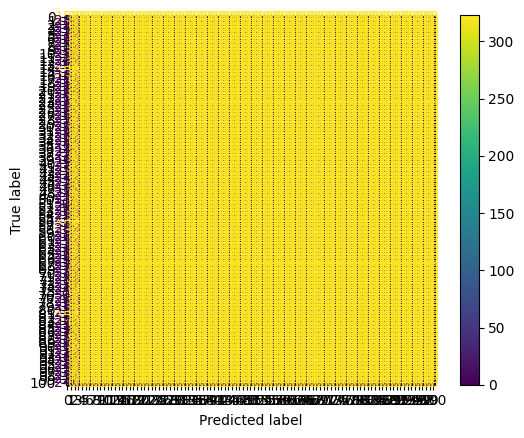

In [ ]:
cfd.plot()

In [ ]:
import numpy as np

def make_confusion_matrix(pred_classes, y_label, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(pred_classes,y_label)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = mpl.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=mpl.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      mpl.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      mpl.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
import itertools

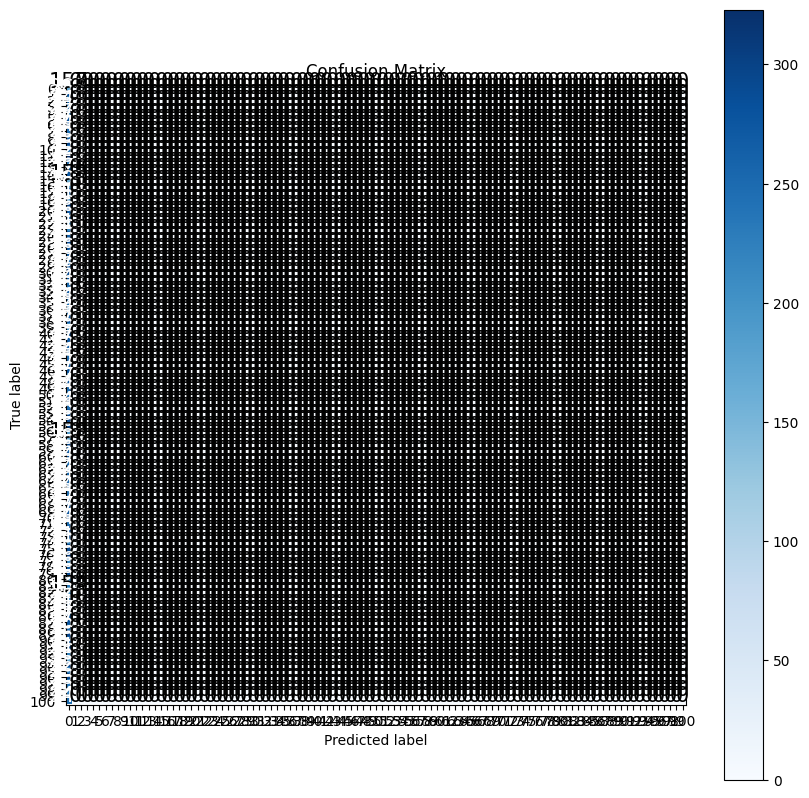

In [ ]:
make_confusion_matrix(pred_classes,y_label)

In [ ]:
label_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
label_names[pred_classes.argmax(axis=0)]

'baby_back_ribs'